# Homework 2, *part 1* (40 points)

This warm-up problem set is provided to help you get used to PyTorch.

Please, only fill parts marked with "`Your code here`".

In [1]:
import numpy as np
import math

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

import torch
assert torch.__version__ >= '1.0.0'

To learn best practices $-$ for example,

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use,

$-$ you are expected to google a lot, read tutorials on the Web and study documentation.

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [2]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor
        out (Tensor, optional): the output tensor
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [3]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

## Task 1 (3 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these values.
3. Convert it into Cartesian coordinates ([howto](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [4]:
# (1) Your code here
theta = torch.linspace(start=-math.pi, end=math.pi, steps=1000)
assert theta.shape == (1000,)

# (2) Your code here
rho = (1 + torch.cos(8*theta)) * (1 + 0.1*torch.cos(24*theta)) * (0.9 + 0.05*torch.cos(200*theta)) * (1 + torch.sin(theta))
assert torch.is_same_size(rho, theta)

# (3) Your code here
x = rho * torch.cos(theta)
y = rho * torch.sin(theta)

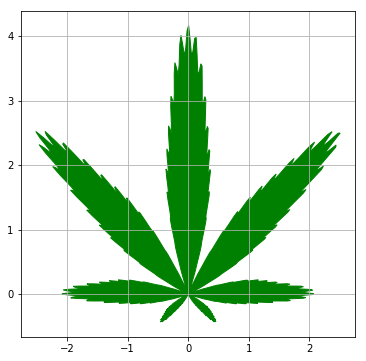

In [5]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=[6,6])
plt.fill(x.numpy(), y.numpy(), color='green')
plt.grid()

## Task 2 (7 points)

Use tensors only: **no lists, loops, numpy arrays etc.**

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

If you skipped the URL above, here are the rules:
* You have a 2D grid of cells, where each cell is "alive"(1) or "dead"(0)
* At one step in time, the generation update happens:
  * Any living cell that has 2 or 3 neighbors survives, otherwise (0,1 or 4+ neighbors) it dies
  * Any cell with exactly 3 neighbors becomes alive if it was dead

You are given a reference numpy implementation of the update step. Your task is to convert it to PyTorch.

In [6]:
from scipy.signal import correlate2d as conv2d

def numpy_update(alive_map):
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]])
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    np.copyto(alive_map, np.logical_or(born, survived))

In [7]:
arr = torch.tensor([[1, 3, 3], [4, 5, 3]]).float()
arr2 = torch.tensor([[7, 8, 5], [5, 6, 5]]).float()
res = (arr == 3) + (arr2==5) - (arr == 3) * (arr2==5)
res

tensor([[0, 1, 1],
        [1, 0, 1]], dtype=torch.uint8)

In [8]:
arr = np.array([[1, 2, 3], [4, 5, 3]])
arr2 = np.array([[7, 8, 5], [0, 5, 5]])
res1 = np.isin(arr, [5, 4])
res2 = (arr == 5) + (arr == 4)
res1 == res2

array([[ True,  True,  True],
       [ True,  True,  True]])

In [9]:
def torch_update(alive_map):
    """
    Game of Life update function that does to `alive_map` exactly the same as `numpy_update`.
    
    :param alive_map: `torch.tensor` of shape `(height, width)` and dtype `torch.float32`
        containing 0s (dead) an 1s (alive)
    """
    # Your code here
    conv_kernel = torch.tensor(np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]])).type(torch.FloatTensor)
    conv_kernel = conv_kernel.reshape(1, 1, conv_kernel.shape[0], conv_kernel.shape[1])
    alive_map = alive_map.reshape(1, 1, alive_map.shape[0], alive_map.shape[1])
    num_alive_neighbors = torch.nn.functional.conv2d(alive_map, conv_kernel, padding=1)
    born = torch.mul(
        torch.eq(num_alive_neighbors, 3), 
        torch.eq(alive_map, 0)).type(torch.FloatTensor)
    survived = torch.mul(
        torch.eq(alive_map, 1), 
        torch.add(
            torch.eq(num_alive_neighbors, 2), 
            torch.eq(num_alive_neighbors, 3))).type(torch.FloatTensor)
    torch.add(born, 
              (torch.add(
                  survived, 
                  torch.neg(torch.mul(born, survived)))), out=alive_map)

In [10]:
# Generate a random initial map
alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
alive_map_torch = torch.tensor(alive_map_numpy).float().clone()

numpy_update(alive_map_numpy)
torch_update(alive_map_torch)

# results should be identical
assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
    "Your PyTorch implementation doesn't match numpy_update."
print("Well done!")

Well done!


<IPython.core.display.Javascript object>


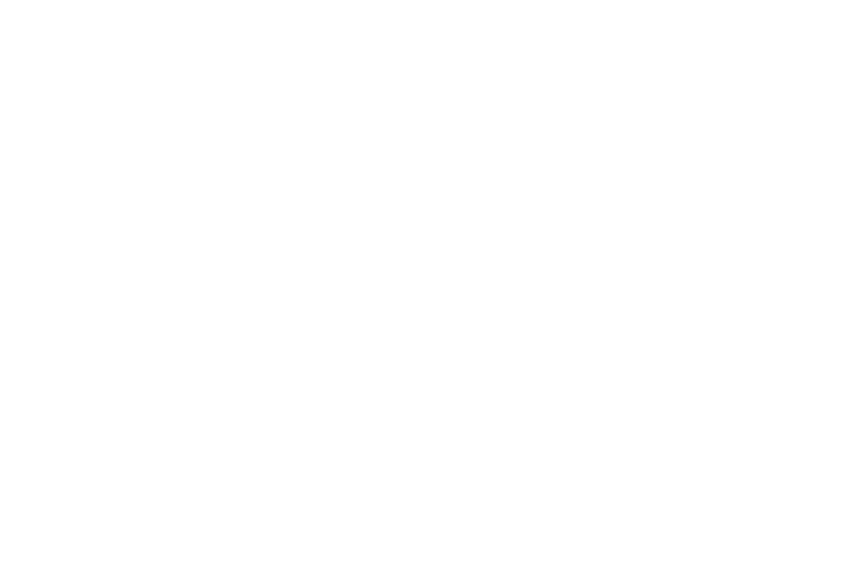

<IPython.core.display.Javascript object>


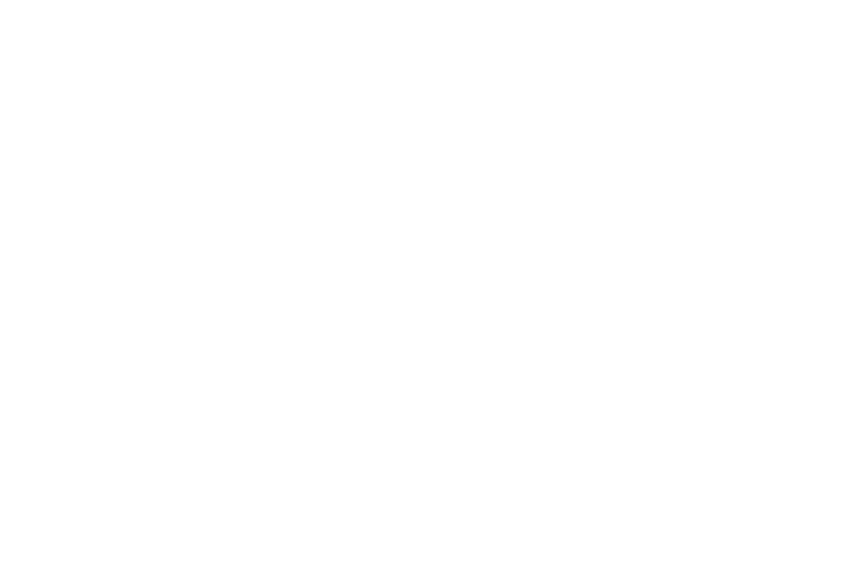

In [11]:
%matplotlib notebook
plt.ion()

# initialize game field
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(100):
    torch_update(alive_map)
    
    # re-draw image
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

<IPython.core.display.Javascript object>


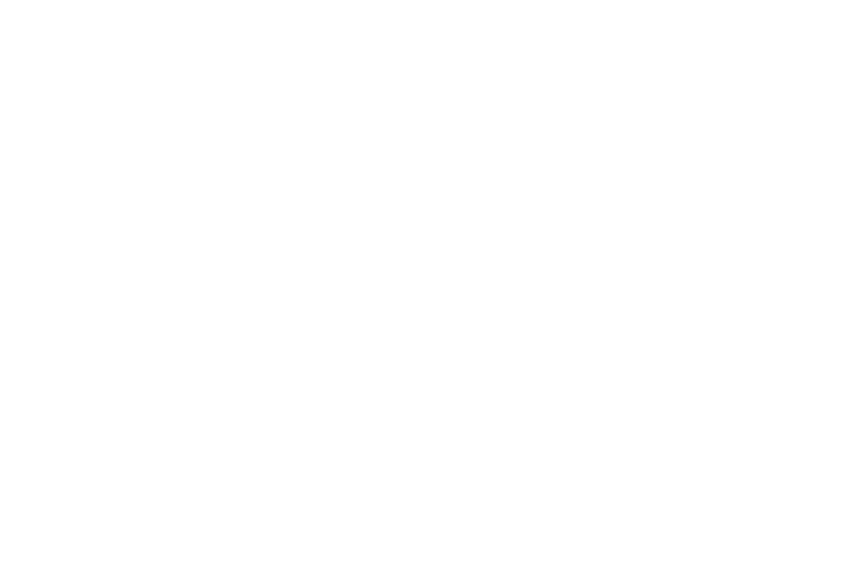

<IPython.core.display.Javascript object>


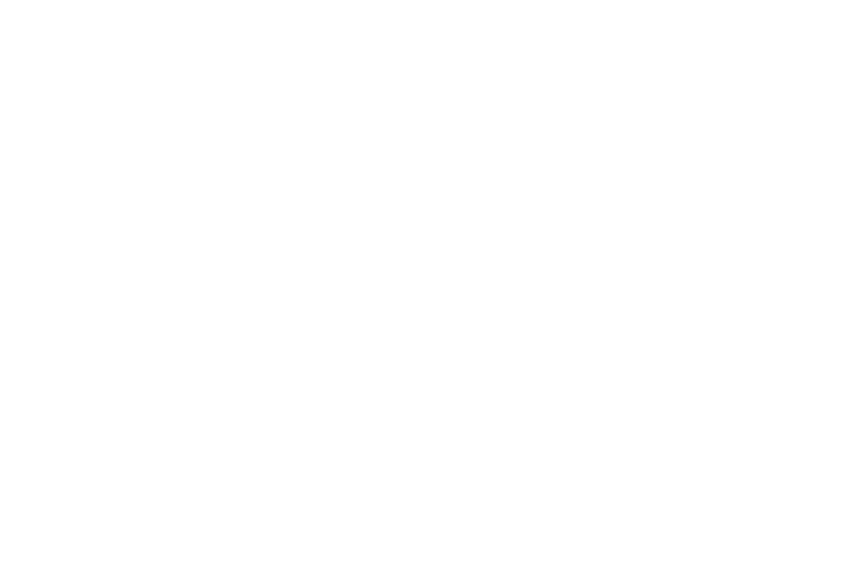

In [12]:
# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros([100, 100])
alive_map[48:52, 50] = 1

alive_map = torch.tensor(alive_map).float()

fig = plt.figure()
ax = fig.add_subplot(111)
fig.show()

for _ in range(150):
    torch_update(alive_map)
    ax.clear()
    ax.imshow(alive_map.numpy(), cmap='gray')
    fig.canvas.draw()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: 10 letters, ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% accuracy
2. at least 2 linear layers
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/)

**You are NOT allowed to use**
* numpy arrays
* `torch.nn`, `torch.optim`
* convolutions

Tips:

* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

**Reproducibility requirement**: you have to format your code cells so that `Cell -> Run All` on a fresh notebook **reliably** trains your model to the desired accuracy in a couple of minutes and reports the accuracy reached.

Happy googling!

In [13]:
np.random.seed(666)
torch.manual_seed(666)

from notmnist import load_notmnist
letters = 'ABCDEFGHIJ' 
X_train, y_train, X_test, y_test = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_test.squeeze_();

Parsing...
found broken img: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png [it's ok if <10 images are broken]
found broken img: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png [it's ok if <10 images are broken]


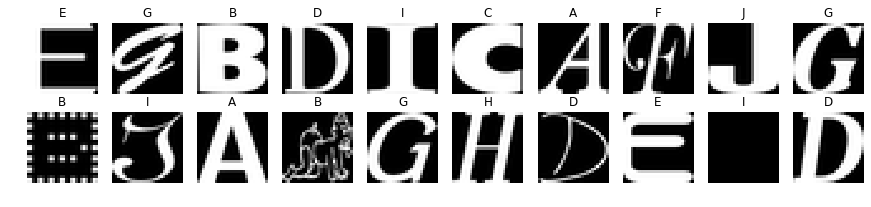

In [14]:
%matplotlib inline
fig, axarr = plt.subplots(2, 10, figsize=(15,3))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx].numpy(), cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [15]:
def one_hot_encode(labels, n_classes):
    return torch.eye(n_classes)[labels]

def accuracy(model, images, labels):
    """
    model: `NeuralNet`
    images: `torch.tensor` of shape `N x height x width`
        and dtype `torch.float32`
    labels: `torch.tensor` of shape `N` and dtype `torch.int64`. Contains
        class index for each sample
    
    returns:
        fraction of samples from `images` correctly classified by `model`
    """
    pred_probs = model.predict(images)
    pred_labels = torch.argmax(pred_probs, dim=1)
    return ((pred_labels == labels).sum().float() / labels.shape[0]).data

def cross_entropy_criterion(predictions, y):
    EPS = 1e-15
    predictions_clamp = torch.clamp(predictions, EPS, 1-EPS)
    loss = -torch.sum(torch.mul(y, torch.log(predictions_clamp))) / y.shape[0]
    return loss

class NeuralNet:
    def __init__(self, linear_sizes, criterion):
        # Your code here
        self.linear_sizes = linear_sizes
        self.criterion = criterion
        self.__make_layers()
        
    # Public methods
    def train(self, X_train, y_train, X_test=None, y_test=None, n_classes=10, lr=0.01, n_epoch=20, batch_size=100):
        X_train_reshaped = X_train.reshape(X_train.shape[0], -1)
        y_train_encoded = one_hot_encode(y_train, n_classes)
        loss_train_history = []
        accuracy_train_history = []
        if X_test is not None and y_test is not None:
            X_test_reshaped = X_test.reshape(X_test.shape[0], -1)
            y_test_encoded = one_hot_encode(y_test, n_classes)
            loss_test_history = []
            accuracy_test_history = []
        for n in range(n_epoch):
            display.clear_output(wait=True)
            for x_batch, y_batch in self.__get_batches((X_train_reshaped, y_train_encoded), batch_size):
                predictions = self.__forward(x_batch)
                loss = self.criterion(predictions, y_batch)
                self.__backward(loss)
                self.__do_grad_step(lr)
                self.__zero_grads()
              
            print('Epoch {}'.format(n+1))
            plt.figure(figsize=(16, 20))
            plt.subplot(2, 1, 1)
            plt.title("Loss", fontsize=18)
            plt.xlabel("Epoch", fontsize=18)
            plt.ylabel("Loss", fontsize=18)
            loss_train_history.append(self.criterion(self.__forward(X_train_reshaped), y_train_encoded))
            plt.plot(loss_train_history, label='Train Loss')
            if X_test is not None and y_test is not None:
                loss_test_history.append(self.criterion(self.__forward(X_test_reshaped), y_test_encoded))
                plt.plot(loss_test_history, label='Test Loss')
            plt.legend()
            plt.subplot(2, 1, 2)
            plt.title("Accuracy", fontsize=18)
            plt.xlabel("Epoch", fontsize=18)
            plt.ylabel("Accuracy", fontsize=18)
            accuracy_train_history.append(float(accuracy(self, X_train, y_train)))
            plt.plot(accuracy_train_history, label='Train Accuracy')
            if X_test is not None and y_test is not None:
                accuracy_test_history.append(float(accuracy(self, X_test, y_test)))
                plt.plot(accuracy_test_history, label='Test Accuracy')
            plt.legend()
            plt.show()
        return None
    
    def predict(self, images):
        """
        images: `torch.tensor` of shape `batch_size x height x width`
            and dtype `torch.float32`.
        
        returns: `output`, a `torch.tensor` of shape `batch_size x 10`,
            where `output[i][j]` is the probability of `i`-th
            batch sample to belong to `j`-th class.
        """
        # Your code here
        imgs = images.reshape(images.shape[0], -1)
        predictions = self.__forward(imgs)
        return predictions    
        
    # Private methods
    def __forward(self, X):
        res = X.mm(self.W[0]) + self.b[0]
        for i in range(1, len(self.W)):
            res = torch.relu(res)
            res = torch.mm(res, self.W[i]) + self.b[i]
        predictions = torch.softmax(res, dim=1)
        return predictions
        
    def __backward(self, loss):
        loss.backward()
        return None

    def __make_layers(self):
        self.W = []
        self.b = []
        for size in self.linear_sizes:
            tensor_w = torch.randn((size[0], size[1]), requires_grad=True).float()
            tensor_w.data *= 0.01
            self.W.append(tensor_w)
            tensor_b = torch.randn((size[1]), requires_grad=True).float()
            tensor_b.data *= 0.01
            self.b.append(tensor_b)
        return None
    
    def __get_batches(self, dataset, batch_size=100):
        X, Y = dataset
        n_samples = X.shape[0]
        indices = torch.randperm(n_samples)    
        for start in range(0, n_samples, batch_size):
            end = min(start + batch_size, n_samples)
            batch_idx = indices[start:end]
            yield X[batch_idx], Y[batch_idx]
            
    def __do_grad_step(self, lr=0.01):
        for i in range(len(self.W)):
            self.W[i].data -= lr * self.W[i].grad.data
            self.b[i].data -= lr * self.b[i].grad.data
        return None
    
    def __zero_grads(self):
        for w, b in zip(self.W, self.b):
            w.grad.data.zero_()
            b.grad.data.zero_()
        return None

Epoch 50


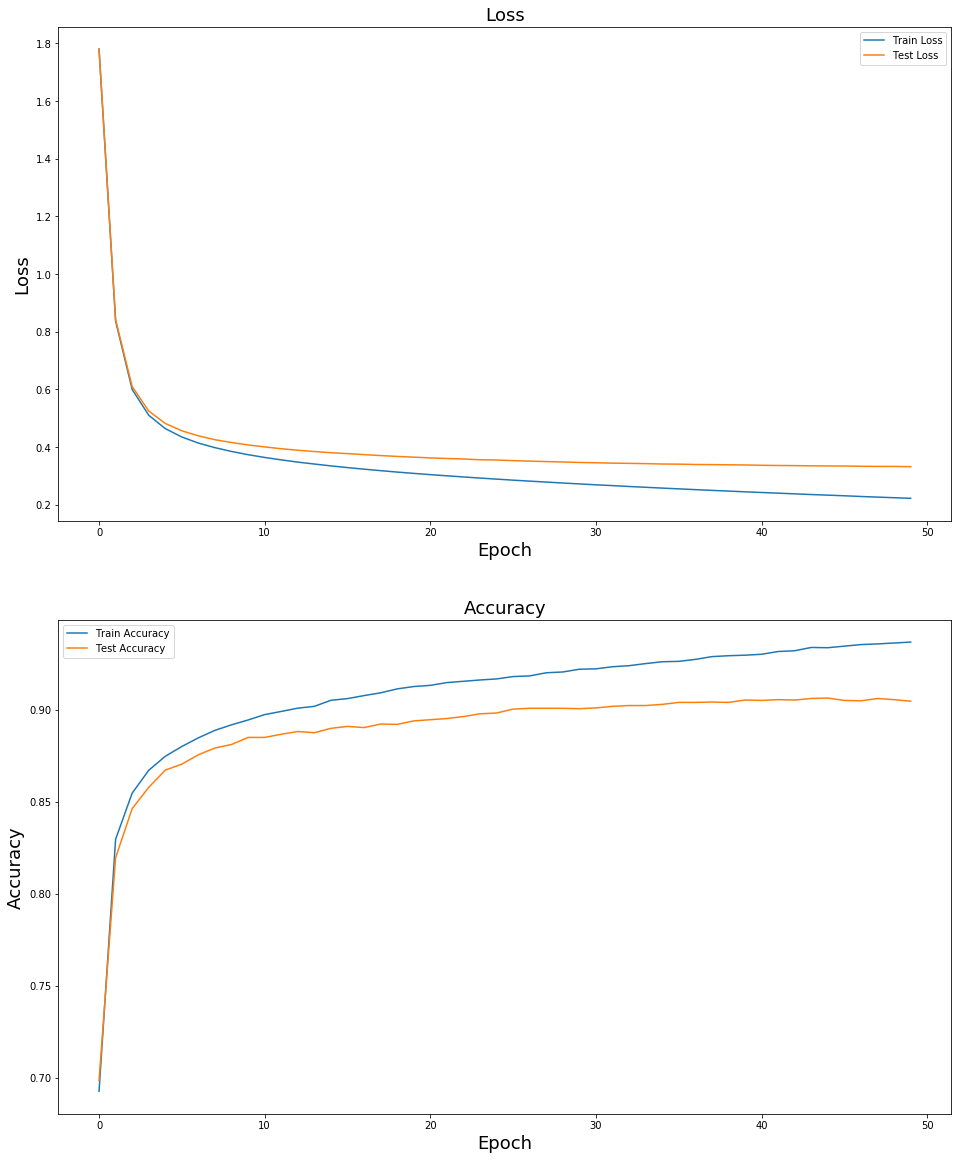

In [18]:
x, y = X_train.shape[1], X_train.shape[2]
linear_sizes = [[x*y, 100], [100, 10]]
model = NeuralNet(linear_sizes, cross_entropy_criterion)
model.train(X_train, y_train, X_test, y_test, n_classes=10, n_epoch = 50, lr = 0.01, batch_size=100)

In [22]:
train_acc = accuracy(model, X_train, y_train) * 100
test_acc = accuracy(model, X_test, y_test) * 100
print("Train accuracy: %.2f%%, test accuracy: %.2f%%" % (train_acc, test_acc))

assert test_acc >= 82.0, "You have to do better"

Train accuracy: 93.66%, test accuracy: 90.45%
